# Logistic Regression - 2005 Moscow Blackout

We are going to load the consolidated features for the incident and color the anomaly intervals.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Specify the incident ID (e.g., replace with the relevant identifier)
INCIDENT = "2005-moscow-blackout"  # Replace with the actual incident identifier
COLLECTOR = "rrc05"
WINDOW = "w06s"

# File path for the consolidated features CSV
file_path = f"../../features/{INCIDENT}/{WINDOW}/consolidated_features_{COLLECTOR}.csv"

# Load the consolidated features file into merged_df
merged_df = pd.read_csv(file_path)

# Ensure timestamp is parsed as a datetime object
merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'])

# Define anomaly intervals to highlight (as datetime or numeric values)
anomaly_intervals = [
    ("2005-05-24 22:10:09","2005-05-24 22:51:09"),
    ("2005-05-24 23:26:09","2005-05-24 23:52:09"),
    ("2005-05-25 04:24:09","2005-05-25 07:24:09"),
    ("2005-05-25 08:08:09","2005-05-25 09:09:09"),
    ("2005-05-26 19:02:09","2005-05-26 20:44:09")
]

anomaly_intervals

[('2005-05-24 22:10:09', '2005-05-24 22:51:09'),
 ('2005-05-24 23:26:09', '2005-05-24 23:52:09'),
 ('2005-05-25 04:24:09', '2005-05-25 07:24:09'),
 ('2005-05-25 08:08:09', '2005-05-25 09:09:09'),
 ('2005-05-26 19:02:09', '2005-05-26 20:44:09')]

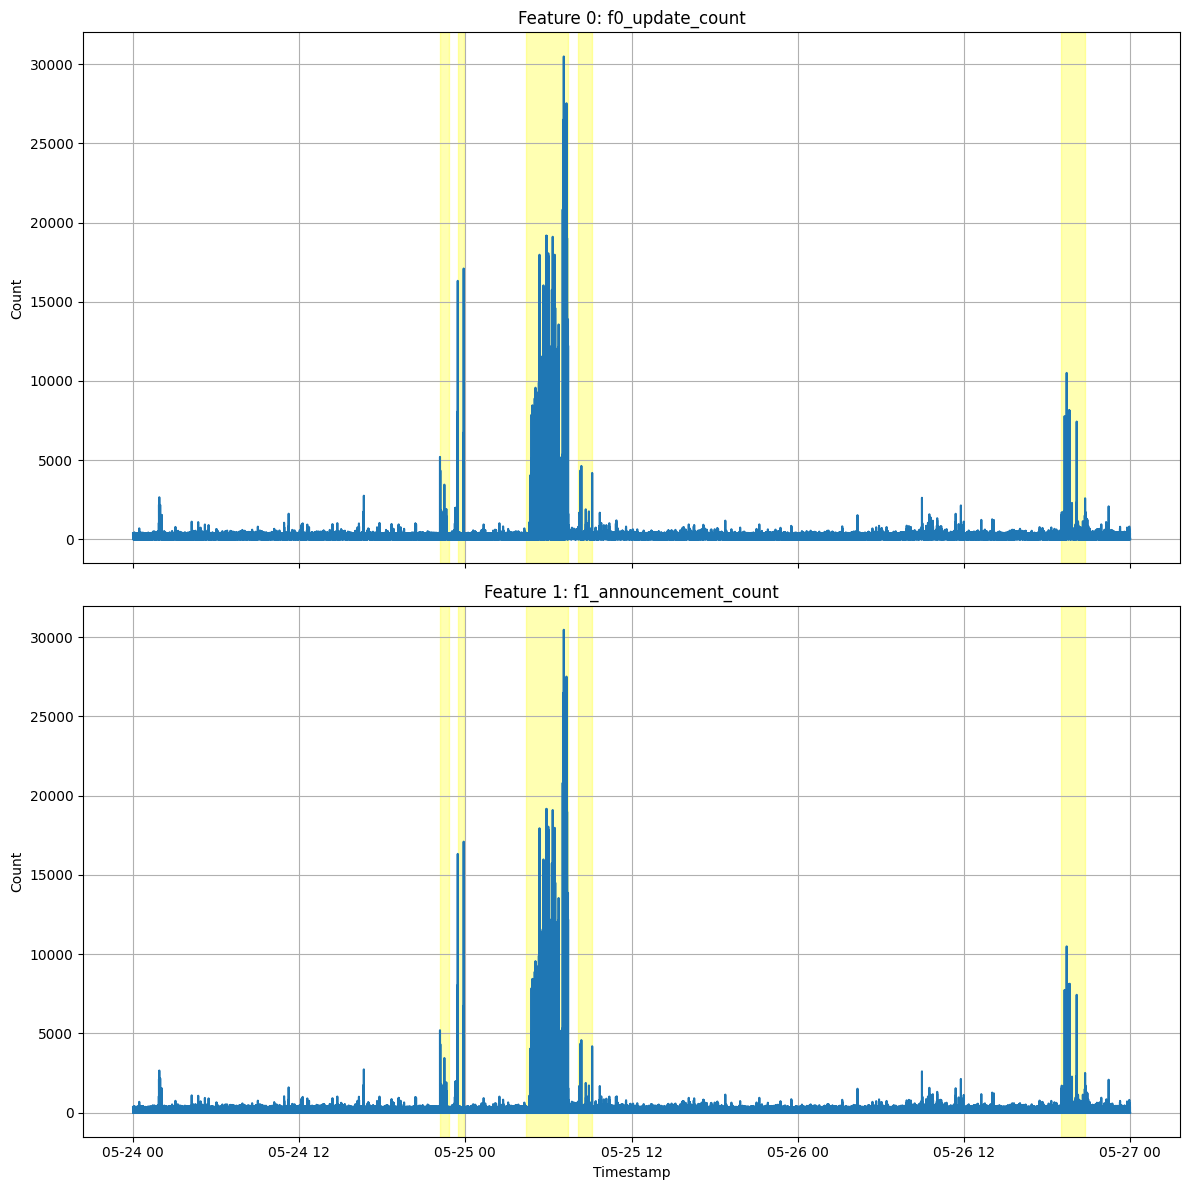

In [2]:
# Plotting
# fig, axs = plt.subplots(len(merged_df.columns) - 1, 1, figsize=(12, 12), sharex=True)
fig, axs = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

# Plot each feature dynamically and highlight anomaly intervals
for i, (col, ax) in enumerate(zip(merged_df.columns[1:], axs)):  # Skip 'timestamp'
    ax.plot(merged_df['timestamp'], merged_df[col])
    ax.set_title(f"Feature {i}: {col}")
    ax.set_ylabel("Count")
    ax.grid(True)
    
    # Add background highlights for anomalies
    for start, end in anomaly_intervals:
        ax.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='yellow', alpha=0.3)

# Add xlabel to the last subplot
axs[-1].set_xlabel("Timestamp")

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

In [3]:
# Ensure anomaly_intervals are in datetime format
anomaly_intervals = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in anomaly_intervals]

# Create anomaly_df with timestamp column
anomaly_df = pd.DataFrame({'timestamp': merged_df['timestamp']})

# Initialize anomaly column with 0 (no anomaly)
anomaly_df['anomaly'] = 0

# Mark intervals with anomalies as 1
for start, end in anomaly_intervals:
    anomaly_df.loc[(anomaly_df['timestamp'] >= start) & (anomaly_df['timestamp'] <= end), 'anomaly'] = 1

# Preview the resulting dataframe
print(anomaly_df.head())

            timestamp  anomaly
0 2005-05-24 00:00:09        0
1 2005-05-24 00:00:15        0
2 2005-05-24 00:00:21        0
3 2005-05-24 00:00:27        0
4 2005-05-24 00:00:33        0


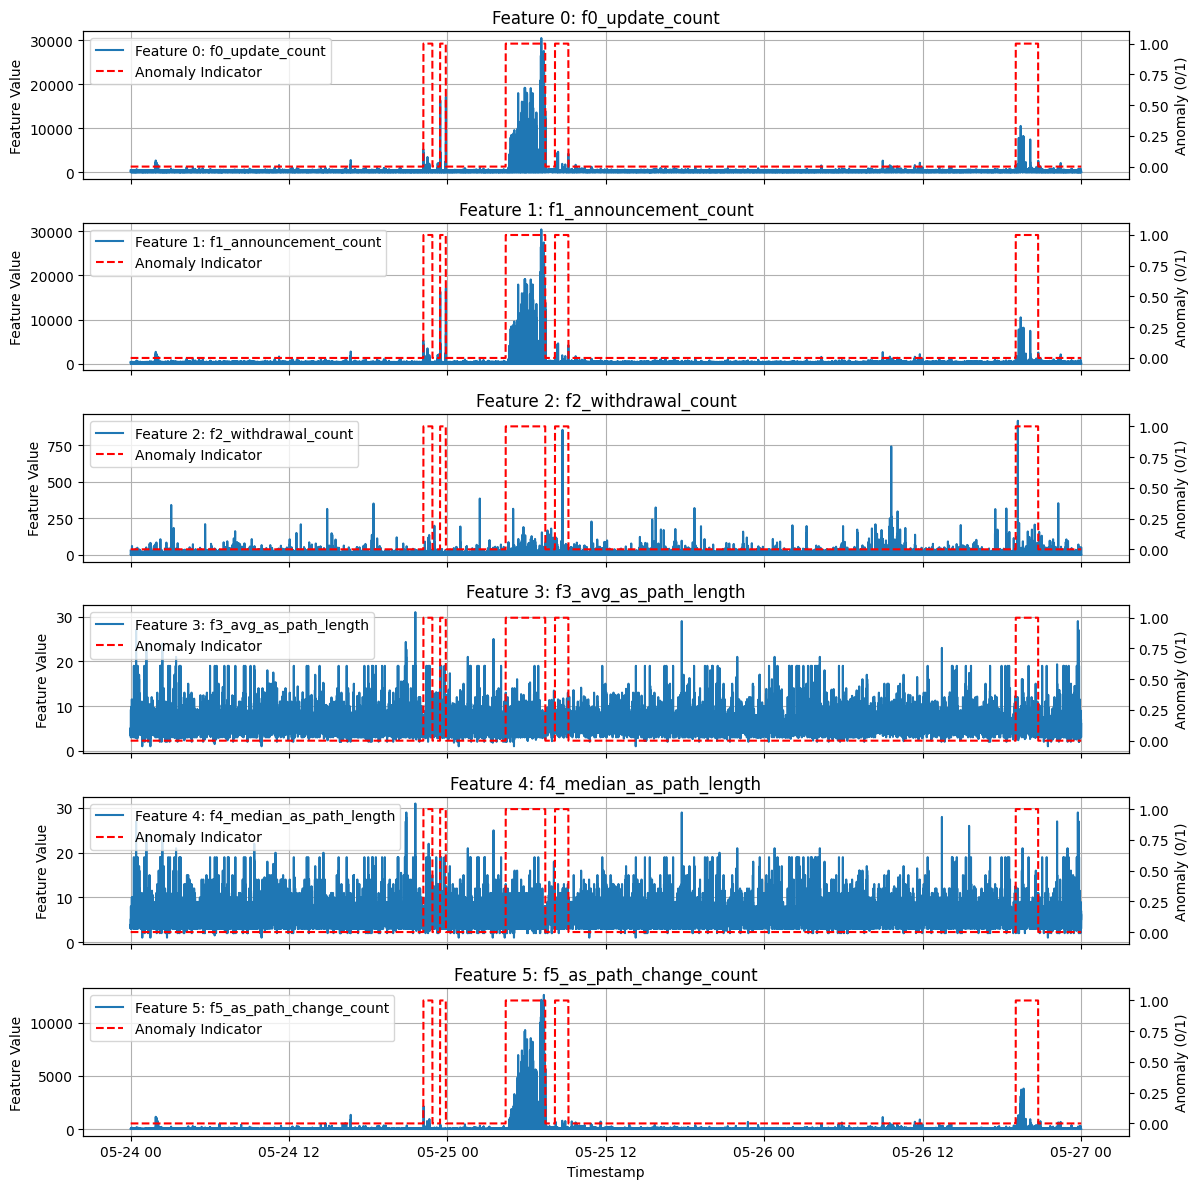

In [4]:
### -------------------------------------------
# Plotting
fig, axs = plt.subplots(len(merged_df.columns) - 1, 1, figsize=(12, 12), sharex=True)

# Plot each feature dynamically and overlay the anomaly indicator
for i, (col, ax) in enumerate(zip(merged_df.columns[1:], axs)):  # Skip 'timestamp'
    # Plot the feature
    ax.plot(merged_df['timestamp'], merged_df[col], label=f"Feature {i}: {col}")
    ax.set_title(f"Feature {i}: {col}")
    ax.set_ylabel("Feature Value")
    ax.grid(True)
    
    # Add the anomaly indicator on a secondary Y-axis
    ax2 = ax.twinx()
    ax2.plot(anomaly_df['timestamp'], anomaly_df['anomaly'], color='red', linestyle='--', label="Anomaly Indicator")
    ax2.set_ylabel("Anomaly (0/1)")
    ax2.set_ylim(-0.1, 1.1)  # Ensure the anomaly values fit well visually
    
    # Combine legends from both axes
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, loc="upper left")

# Add xlabel to the last subplot
axs[-1].set_xlabel("Timestamp")

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

## Split datasets

We will split our data into training and validation sets.

In [5]:
# Convert timestamps to a NumPy array before shuffling
timestamps = np.array(merged_df['timestamp'].unique())  # Explicitly convert to NumPy array
TRAINING_SPLIT = 0.75

# Shuffle timestamps and split according TRAINING_SPLIT
np.random.seed(42)  # For reproducibility
np.random.shuffle(timestamps)

# Split timestamps into training and validation sets
split_index = int(TRAINING_SPLIT * len(timestamps))
train_timestamps = timestamps[:split_index]
val_timestamps = timestamps[split_index:]

# Split the data based on the sampled timestamps
train_features = merged_df[merged_df['timestamp'].isin(train_timestamps)]
val_features = merged_df[merged_df['timestamp'].isin(val_timestamps)]

train_labels = anomaly_df[anomaly_df['timestamp'].isin(train_timestamps)]
val_labels = anomaly_df[anomaly_df['timestamp'].isin(val_timestamps)]

# Verify timestamps
print("Training Range:", train_features["timestamp"].min(), "to", train_features["timestamp"].max())
print("Validation Range:", val_features["timestamp"].min(), "to", val_features["timestamp"].max())
print("Full Range:", merged_df["timestamp"].min(), "to", merged_df["timestamp"].max())

# Reset indices for clean DataFrames
train_features = train_features.reset_index(drop=True)
val_features = val_features.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)

# Verify split sizes
print("Training Features Shape:", train_features.shape)
print("Validation Features Shape:", val_features.shape)
print("Training Labels Shape:", train_labels.shape)
print("Validation Labels Shape:", val_labels.shape)


Training Range: 2005-05-24 00:00:09 to 2005-05-26 23:59:57
Validation Range: 2005-05-24 00:00:21 to 2005-05-26 23:59:45
Full Range: 2005-05-24 00:00:09 to 2005-05-26 23:59:57
Training Features Shape: (32399, 7)
Validation Features Shape: (10800, 7)
Training Labels Shape: (32399, 2)
Validation Labels Shape: (10800, 2)


## Train a logistic regressor

Train a logistic regressor with our data and validate it.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Prepare training and validation data
# X_train = train_features.drop(columns=["timestamp"])  # Drop timestamp column for features
# X_val = val_features.drop(columns=["timestamp"])

######
# Specify the features to use for training
selected_features = ['f0_update_count', 'f4_median_as_path_length']  # Example: Use only these two features

# Filter the training and validation features
X_train = train_features[selected_features]
X_val = val_features[selected_features]

# Prepare the labels
y_train = train_labels["anomaly"]
y_val = val_labels["anomaly"]

# Verify the shapes of the selected features
print("Selected Training Features Shape:", X_train.shape)
print("Selected Validation Features Shape:", X_val.shape)
######

y_train = train_labels["anomaly"]  # Use the anomaly column as the target
y_val = val_labels["anomaly"]

# Train the logistic regression model
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)

# Predictions
y_train_pred = log_reg.predict(X_train)
y_val_pred = log_reg.predict(X_val)

# Evaluation
print("Training Classification Report:\n", classification_report(y_train, y_train_pred))
print("Validation Classification Report:\n", classification_report(y_val, y_val_pred))

# Confusion matrix for validation set
conf_matrix = confusion_matrix(y_val, y_val_pred)
print("Validation Confusion Matrix:\n", conf_matrix)


Selected Training Features Shape: (32399, 2)
Selected Validation Features Shape: (10800, 2)
Training Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95     29324
           1       0.95      0.08      0.15      3075

    accuracy                           0.91     32399
   macro avg       0.93      0.54      0.55     32399
weighted avg       0.92      0.91      0.88     32399

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95      9770
           1       0.96      0.09      0.16      1030

    accuracy                           0.91     10800
   macro avg       0.94      0.54      0.56     10800
weighted avg       0.92      0.91      0.88     10800

Validation Confusion Matrix:
 [[9766    4]
 [ 938   92]]


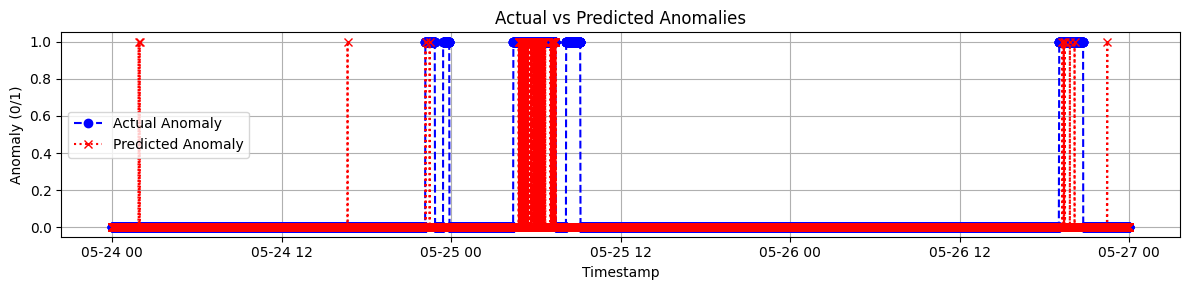

In [7]:
import matplotlib.pyplot as plt

# Plot actual vs predicted for validation set
plt.figure(figsize=(12, 3))
plt.plot(val_features["timestamp"], y_val, label="Actual Anomaly", color="blue", marker='o', linestyle="--")
plt.plot(val_features["timestamp"], y_val_pred, label="Predicted Anomaly", color="red", marker='x', linestyle=":")
plt.xlabel("Timestamp")
plt.ylabel("Anomaly (0/1)")
plt.title("Actual vs Predicted Anomalies")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
val_features.head()

,timestamp,f0_update_count,f1_announcement_count,f2_withdrawal_count,f3_avg_as_path_length,f4_median_as_path_length,f5_as_path_change_count
0,2005-05-24 00:00:21,5,3,1.0,3.333333,3.0,2
1,2005-05-24 00:01:03,342,331,5.0,5.138973,5.0,13
2,2005-05-24 00:01:09,37,34,1.0,6.382353,5.0,15
3,2005-05-24 00:01:21,17,14,1.0,4.142857,4.0,5
4,2005-05-24 00:01:45,43,21,7.0,5.619048,5.0,10
